# Qwen3 — Embeddings & Architecture (Safetensors + Tokenizer)

This notebook reads a Qwen3 `.safetensors` model using the official **safetensors** library,
parses the **model architecture** (attention, MLP, norms) by inspecting tensor names and shapes,
loads a **tokenizer.json**, and evaluates embeddings on two input C functions.

## 1) Install required packages

In [ ]:
# Run this in your own environment (internet required)
!pip install safetensors numpy matplotlib transformers

## 2) Configuration

In [42]:
# Path to your model .safetensors file
FILE_PATH = "./model.safetensors"  # <-- change this

# Path to a tokenizer.json (HuggingFace fast tokenizer format)
TOKENIZER_JSON = "./tokenizer.json"      # <-- change this

# How many tensor entries to print when listing
PRINT_TENSOR_LIMIT = 400  # set None to print all (can be very verbose)

# Embedding tensor auto-detection: will use any of these if present
EMBED_TENSOR_CANDIDATES = [
    "model.embed_tokens.weight",
    "embed_tokens.weight",
    "tok_embeddings.weight",
    "transformer.wte.weight",
    "model.tok_embeddings.weight",
    "embeddings.word_embeddings.weight",
    "wte.weight",
    "word_embeddings.weight",
]

## 3) Load tokenizer.json

In [43]:
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(tokenizer_file=TOKENIZER_JSON)
print("Tokenizer loaded.")
print("Vocab size:", tokenizer.vocab_size)
print("Special tokens:", tokenizer.special_tokens_map)

Tokenizer loaded.
Vocab size: 151643
Special tokens: {}


## 4) Open safetensors and list tensors

In [ ]:
from safetensors import safe_open

with safe_open(FILE_PATH, framework="pt") as f:
    keys = list(f.keys())
    keys.sort()
    print("Total tensors:", len(keys))
    for i, name in enumerate(keys):
        t = f.get_tensor(name)
        print(f"{i:5d} | {name:60s} shape={tuple(t.shape)} dtype={t.dtype}")
        if PRINT_TENSOR_LIMIT is not None and i + 1 >= PRINT_TENSOR_LIMIT:
            print("... truncated list; increase PRINT_TENSOR_LIMIT to see more")
            break


Total tensors: 310
    0 | embed_tokens.weight                                          shape=(151669, 1024) dtype=torch.bfloat16
    1 | layers.0.input_layernorm.weight                              shape=(1024,) dtype=torch.bfloat16
    2 | layers.0.mlp.down_proj.weight                                shape=(1024, 3072) dtype=torch.bfloat16
    3 | layers.0.mlp.gate_proj.weight                                shape=(3072, 1024) dtype=torch.bfloat16
    4 | layers.0.mlp.up_proj.weight                                  shape=(3072, 1024) dtype=torch.bfloat16
    5 | layers.0.post_attention_layernorm.weight                     shape=(1024,) dtype=torch.bfloat16
    6 | layers.0.self_attn.k_norm.weight                             shape=(128,) dtype=torch.bfloat16
    7 | layers.0.self_attn.k_proj.weight                             shape=(1024, 1024) dtype=torch.bfloat16
    8 | layers.0.self_attn.o_proj.weight                             shape=(1024, 2048) dtype=torch.bfloat16
    9 | layers

AttributeError: 'Qwen3Model' object has no attribute 'model'

## 5) Detect the embedding matrix

In [45]:
with safe_open(FILE_PATH, framework="pt") as f:
    keys = set(f.keys())
    embed_name = None
    for cand in EMBED_TENSOR_CANDIDATES:
        if cand in keys:
            embed_name = cand
            break
    if embed_name is None:
        # fallback heuristic: pick a 2D floating tensor with the largest number of elements
        best = None
        for name in f.keys():
            t = f.get_tensor(name)
            if len(t.shape) == 2 and t.is_floating_point():
                numel = t.numel()
                if best is None or numel > best[0]:
                    best = (numel, name, tuple(t.shape), str(t.dtype))
        if best is not None:
            embed_name = best[1]
            print("Auto-selected 2D float tensor as embedding:", embed_name, best[2], best[3])
        else:
            raise RuntimeError("Embedding tensor not found.")
    else:
        print("Detected embedding tensor:", embed_name)
        
    emb = f.get_tensor(embed_name)
    print("Embedding shape:", emb.shape, "dtype:", emb.dtype)
    vocab_size, hidden_size = emb.shape

Detected embedding tensor: embed_tokens.weight
Embedding shape: torch.Size([151669, 1024]) dtype: torch.bfloat16


## 6) Infer model architecture by inspecting tensor names

In [46]:
def build_namespace_tree(keys, sep="."):
    """Convert flat tensor keys into a nested namespace-like dictionary."""
    tree = {}
    for key in keys:
        parts = key.split(sep)
        node = tree
        for p in parts[:-1]:
            node = node.setdefault(p, {})
        node[parts[-1]] = key  # store full path for leaf
    return tree

with safe_open(FILE_PATH, framework="pt") as f:
    keys = list(f.keys())
    tree = build_namespace_tree(keys)

    # --- Embedding ---
    if "embed_tokens" in tree:
        emb_shape = f.get_tensor(tree["embed_tokens"]["weight"]).shape
        print("Embedding:", emb_shape)

    # --- First layer (layer 0) ---
    layer0 = tree["layers"]["0"]
    print("\n=== Layer 0 ===")

    # Attention projections
    q_shape = f.get_tensor(layer0["self_attn"]["q_proj"]["weight"]).shape
    k_shape = f.get_tensor(layer0["self_attn"]["k_proj"]["weight"]).shape
    v_shape = f.get_tensor(layer0["self_attn"]["v_proj"]["weight"]).shape
    o_shape = f.get_tensor(layer0["self_attn"]["o_proj"]["weight"]).shape
    print("Self-Attention projections (q, k, v, o):", q_shape, k_shape, v_shape, o_shape)

    # Optional norms inside attention (if exist, e.g. q_norm, k_norm)
    if "q_norm" in layer0["self_attn"]:
        qn_shape = f.get_tensor(layer0["self_attn"]["q_norm"]["weight"]).shape
        print("q_norm:", qn_shape)
    if "k_norm" in layer0["self_attn"]:
        kn_shape = f.get_tensor(layer0["self_attn"]["k_norm"]["weight"]).shape
        print("k_norm:", kn_shape)

    # MLP projections
    gate_shape = f.get_tensor(layer0["mlp"]["gate_proj"]["weight"]).shape
    up_shape = f.get_tensor(layer0["mlp"]["up_proj"]["weight"]).shape
    down_shape = f.get_tensor(layer0["mlp"]["down_proj"]["weight"]).shape
    print("MLP (gate, up, down):", gate_shape, up_shape, down_shape)

    # Norm layers
    in_ln_shape = f.get_tensor(layer0["input_layernorm"]["weight"]).shape
    post_ln_shape = f.get_tensor(layer0["post_attention_layernorm"]["weight"]).shape
    print("LayerNorms (input, post-attention):", in_ln_shape, post_ln_shape)

    # --- Final norm (after all layers) ---
    if "norm" in tree:
        final_norm_shape = f.get_tensor(tree["norm"]["weight"]).shape
        print("\nFinal norm:", final_norm_shape)




Embedding: torch.Size([151669, 1024])

=== Layer 0 ===
Self-Attention projections (q, k, v, o): torch.Size([2048, 1024]) torch.Size([1024, 1024]) torch.Size([1024, 1024]) torch.Size([1024, 2048])
q_norm: torch.Size([128])
k_norm: torch.Size([128])
MLP (gate, up, down): torch.Size([3072, 1024]) torch.Size([3072, 1024]) torch.Size([1024, 3072])
LayerNorms (input, post-attention): torch.Size([1024]) torch.Size([1024])

Final norm: torch.Size([1024])


## 7) Provide two C functions to compare embeddings

In [47]:
snippet1 = """Node* buildHuffman(char data[], int freq[], int n) {
    MinHeap* heap = (MinHeap*) malloc(sizeof(MinHeap));
    heap->arr = (Node**) malloc(n*2*sizeof(Node*));
    heap->size = 0;
    for (int i=0; i<n; i++) insertHeap(heap, newNode(data[i], freq[i]));
    while (heap->size > 1) {
        Node* l = extractMin(heap);
        Node* r = extractMin(heap);
        Node* merged = newNode('$', l->freq+r->freq);
        merged->left = l; merged->right = r;
        insertHeap(heap, merged);
    }
    return extractMin(heap);
}"""

snippet2 = """Node* buildHuffman(char data[], int freq[], int n) {
    Node** arr = (Node**) malloc(n * sizeof(Node*));
    for (int i=0; i<n; i++) arr[i] = newNode(data[i], freq[i]);
    int size = n;
    while (size > 1) {
        qsort(arr, size, sizeof(Node*), cmp);
        Node* l = arr[0];
        Node* r = arr[1];
        Node* merged = newNode('$', l->freq + r->freq);
        merged->left = l;
        merged->right = r;
        arr[1] = merged;
        memmove(arr, arr+1, (size-1)*sizeof(Node*));
        size--;
    }
    return arr[0];
}"""

CODE_SNIPPETS = [snippet1, snippet2]

print("Loaded", len(CODE_SNIPPETS), "snippets.")
for i, s in enumerate(CODE_SNIPPETS):
    print(f"Snippet {i} length (chars):", len(s))

Loaded 2 snippets.
Snippet 0 length (chars): 524
Snippet 1 length (chars): 538


## 8) Tokenize the snippets and fetch embeddings

In [53]:
import torch
from transformers import AutoTokenizer, AutoModel

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained(".")
model = AutoModel.from_pretrained(".", torch_dtype=torch.float16).to(device)
model.eval()

def tokenize(text):
    """Tokenize text and return ids + tokens (HF tokenizer)."""
    ids = tokenizer.encode(text, add_special_tokens=False)
    toks = tokenizer.convert_ids_to_tokens(ids)
    return ids, toks

def mean_pool_embeddings_from_model(text: str, model, tokenizer, device="cuda"):
    """Get embedding of a snippet using model forward + mean pooling."""
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=False).to(device)
    with torch.no_grad():
        out = model(**enc, output_hidden_states=True)
    # Take last hidden state [seq_len, hidden]
    last_hidden = out.last_hidden_state.squeeze(0)  # remove batch dim
    mean_vec = last_hidden.mean(dim=0)              # [hidden]
    return mean_vec, last_hidden

all_ids = []
all_tokens = []
seq_means = []
seq_vecs = []

for i, text in enumerate(CODE_SNIPPETS):
    ids, toks = tokenize(text)
    all_ids.append(ids)
    all_tokens.append(toks)

    mv, vs = mean_pool_embeddings_from_model(text, model, tokenizer, device=model.device)
    seq_means.append(mv)
    seq_vecs.append(vs)

    print(f"Snippet {i}: tokens={len(ids)} (showing first 40)")
    print("IDs:", ids[:40])
    print("TOK:", toks[:40])

def cosine(a: torch.Tensor, b: torch.Tensor) -> float:
    """Cosine similarity between two 1D torch tensors."""
    a = a.float()
    b = b.float()
    return torch.nn.functional.cosine_similarity(
        a.unsqueeze(0), b.unsqueeze(0), dim=1
    ).item()

print(seq_means[0], seq_means[0].shape)
print(seq_means[1], seq_means[1].shape)

if len(seq_means) == 2 and seq_means[0] is not None and seq_means[1] is not None:
    sim = cosine(seq_means[0], seq_means[1])
    print("Cosine similarity between snippet mean embeddings:", sim)
else:
    print("Unable to compute snippet-level similarity (check tokenizer or model).")


Using device: mps


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Snippet 0: tokens=152 (showing first 40)
IDs: [1955, 9, 1936, 39, 77708, 6933, 821, 12995, 526, 20895, 12995, 526, 308, 8, 341, 262, 3386, 27909, 9, 17364, 284, 320, 6217, 27909, 3764, 15731, 13921, 3189, 258, 27909, 1106, 262, 17364, 405, 1118, 284, 320, 1955, 41942, 15731]
TOK: ['Node', '*', 'Ġbuild', 'H', 'uffman', '(char', 'Ġdata', '[],', 'Ġint', 'Ġfreq', '[],', 'Ġint', 'Ġn', ')', 'Ġ{Ċ', 'ĠĠĠ', 'ĠMin', 'Heap', '*', 'Ġheap', 'Ġ=', 'Ġ(', 'Min', 'Heap', '*)', 'Ġmalloc', '(sizeof', '(M', 'in', 'Heap', '));Ċ', 'ĠĠĠ', 'Ġheap', '->', 'arr', 'Ġ=', 'Ġ(', 'Node', '**)', 'Ġmalloc']
Snippet 1: tokens=168 (showing first 40)
IDs: [1955, 9, 1936, 39, 77708, 6933, 821, 12995, 526, 20895, 12995, 526, 308, 8, 341, 262, 6018, 334, 2890, 284, 320, 1955, 41942, 15731, 1445, 353, 3935, 22078, 9, 1106, 262, 369, 320, 396, 600, 28, 15, 26, 600, 15724]
TOK: ['Node', '*', 'Ġbuild', 'H', 'uffman', '(char', 'Ġdata', '[],', 'Ġint', 'Ġfreq', '[],', 'Ġint', 'Ġn', ')', 'Ġ{Ċ', 'ĠĠĠ', 'ĠNode', '**', 'Ġarr', 'Ġ=', '

## 9) Visualize: value histogram and row norms for tokens used

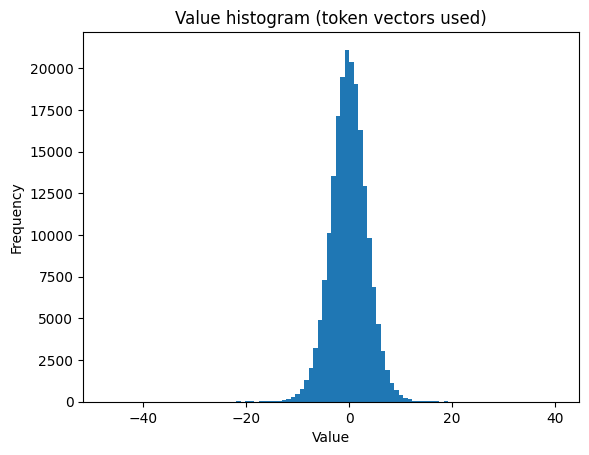

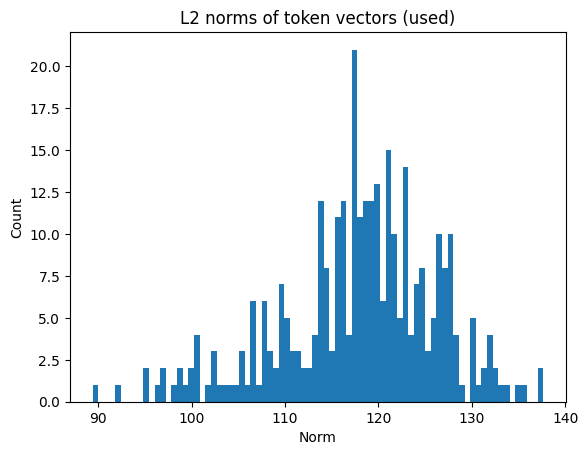

In [54]:
import matplotlib.pyplot as plt

used_vecs = []
for vs in seq_vecs:
    if vs is not None:
        used_vecs.append(vs)

if used_vecs:
    # Concatenate along sequence dimension
    U = torch.cat(used_vecs, dim=0)  # shape: [total_tokens, hidden]

    # Flatten values
    flat = U.reshape(-1)

    # Sample first 200k values for histogram
    sample = flat[:200000].to(torch.float32).cpu().numpy()
    plt.figure()
    plt.hist(sample, bins=100)
    plt.title("Value histogram (token vectors used)")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

    # L2 norms per token vector
    norms = torch.norm(U.to(torch.float32), dim=1)
    norms_np = norms.cpu().numpy()
    plt.figure()
    plt.hist(norms_np, bins=80)
    plt.title("L2 norms of token vectors (used)")
    plt.xlabel("Norm")
    plt.ylabel("Count")
    plt.show()
else:
    print("No token vectors to visualize (empty tokenization?).")


## 10) 2D PCA of token vectors (per snippet)

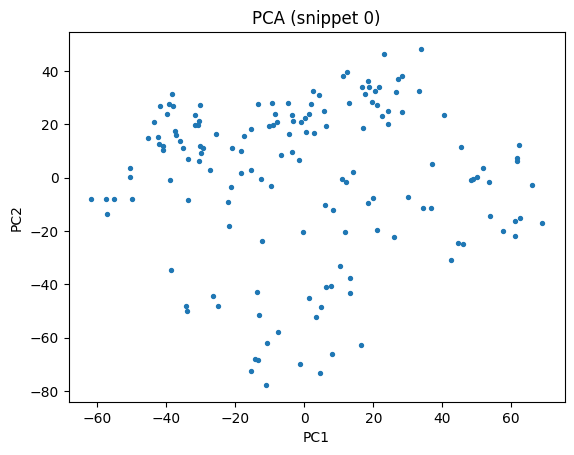

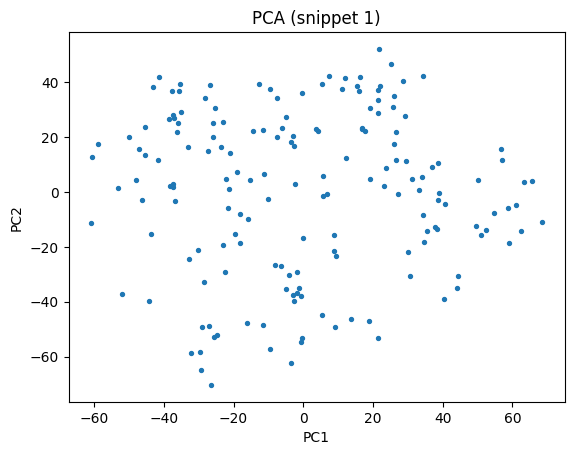

In [55]:
def pca_2d(X: torch.Tensor) -> torch.Tensor:
    """
    Perform 2D PCA on a matrix of shape [n_samples, n_features] using PyTorch.
    Returns coordinates of shape [n_samples, 2].
    """
    # Ensure float32 for compatibility (handles BF16/F16)
    X = X.to(torch.float32)

    # Center the data
    X = X - X.mean(dim=0, keepdim=True)

    # SVD decomposition
    U, S, Vh = torch.linalg.svd(X, full_matrices=False)

    # Project onto the first 2 principal components
    coords = X @ Vh[:2].T
    return coords

# Apply PCA for each snippet
for i, vs in enumerate(seq_vecs):
    if vs is None or vs.shape[0] < 2:
        print(f"Snippet {i}: not enough vectors for PCA.")
        continue

    coords = pca_2d(vs)

    # Convert to numpy only for plotting
    coords_np = coords.cpu().numpy()
    plt.figure()
    plt.scatter(coords_np[:,0], coords_np[:,1], s=8)
    plt.title(f"PCA (snippet {i})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


## 11) QKV and O
- Visualize Q/K/V/O projection matrix shapes for one layer

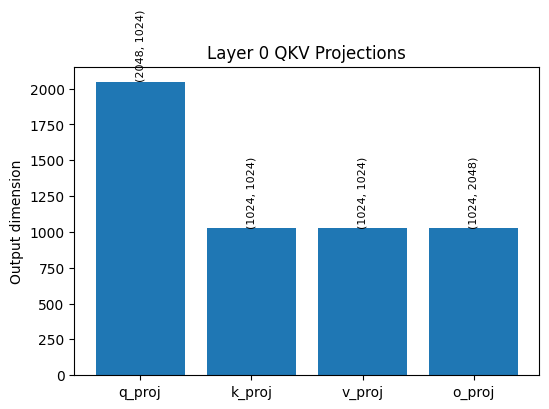

In [57]:
import matplotlib.pyplot as plt

def visualize_qkv_shapes(model, layer_idx=0):
    """Visualize Q/K/V/O projection matrix shapes for one layer."""
    layer = model.layers[layer_idx]
    q, k, v, o = layer.self_attn.q_proj, layer.self_attn.k_proj, layer.self_attn.v_proj, layer.self_attn.o_proj
    
    shapes = {
        "q_proj": tuple(q.weight.shape),
        "k_proj": tuple(k.weight.shape),
        "v_proj": tuple(v.weight.shape),
        "o_proj": tuple(o.weight.shape),
    }

    plt.figure(figsize=(6,4))
    plt.title(f"Layer {layer_idx} QKV Projections")
    bars = plt.bar(shapes.keys(), [s[0] for s in shapes.values()])
    for bar, s in zip(bars, shapes.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(s),
                 ha="center", va="bottom", fontsize=8, rotation=90)
    plt.ylabel("Output dimension")
    plt.show()

visualize_qkv_shapes(model, layer_idx=0)

## 12) Heatmap of attention weights (one layer, one head)
- Visualize attention weights for one layer and one head

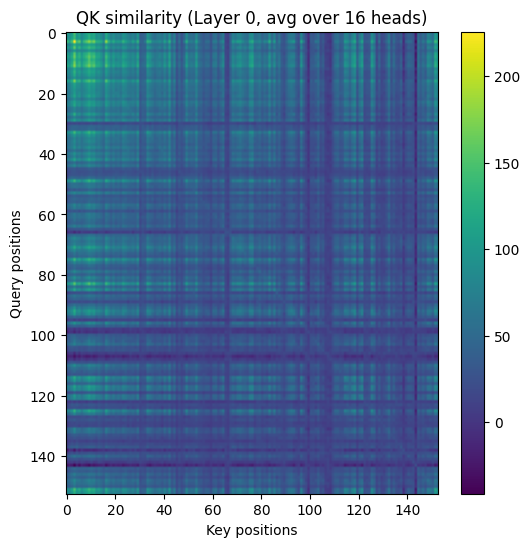

[debug] seq_len=153, q_dim=2048, k_dim=1024, head_dim=128, q_heads=16, k_heads=8


In [63]:
import math
import torch
import matplotlib.pyplot as plt

def _infer_heads_and_dim(model, q_dim: int, k_dim: int):
    num_heads_cfg = getattr(getattr(model, "config", object()), "num_key_value_heads", None)
    hidden_size = getattr(getattr(model, "config", object()), "hidden_size", None)
    head_dim = None

    if num_heads_cfg and hidden_size and hidden_size % num_heads_cfg == 0:
        head_dim = hidden_size // num_heads_cfg
        if q_dim % head_dim != 0:
            head_dim = None

    if head_dim is None and num_heads_cfg and q_dim % num_heads_cfg == 0:
        head_dim = q_dim // num_heads_cfg

    if head_dim is None:
        head_dim = math.gcd(int(q_dim), int(k_dim))
        if head_dim <= 1:
            for d in (128, 96, 80, 64, 48, 32):
                if q_dim % d == 0 and k_dim % d == 0:
                    head_dim = d
                    break
            if head_dim <= 1:
                head_dim = q_dim

    q_heads = max(1, q_dim // head_dim)
    k_heads = max(1, k_dim // head_dim)
    return q_heads, k_heads, head_dim

def visualize_attention_qk(text, model, tokenizer, layer_idx=0, device="cpu"):
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=False).to(device)
    with torch.no_grad():
        hidden = model(**enc, output_hidden_states=True).last_hidden_state
    hidden = hidden.to(torch.float32)

    layer = model.layers[layer_idx]
    Q = layer.self_attn.q_proj(hidden).squeeze(0).to(torch.float32)
    K = layer.self_attn.k_proj(hidden).squeeze(0).to(torch.float32)

    seq_len = Q.shape[0]
    q_dim, k_dim = Q.shape[-1], K.shape[-1]
    q_heads, k_heads, head_dim = _infer_heads_and_dim(model, q_dim, k_dim)

    Q = Q[:, :q_heads * head_dim].contiguous().view(seq_len, q_heads, head_dim)
    K = K[:, :k_heads * head_dim].contiguous().view(seq_len, k_heads, head_dim)

    if q_heads != k_heads:
        if q_heads % k_heads == 0:
            K = K.repeat_interleave(q_heads // k_heads, dim=1)
        elif k_heads % q_heads == 0:
            Q = Q.repeat_interleave(k_heads // q_heads, dim=1)
        else:
            common = math.gcd(q_heads, k_heads)
            Q = Q[:, :common, :]
            K = K[:, :common, :]
            q_heads = k_heads = common

    sim = torch.einsum("shd,thd->hst", Q, K) / (head_dim ** 0.5)
    sim_mean = sim.mean(dim=0).detach().cpu()   # <--- no numpy

    # Use torch for plotting (matplotlib accepts torch.Tensor if on CPU)
    plt.figure(figsize=(6, 6))
    plt.imshow(sim_mean, aspect="auto")
    plt.colorbar()
    plt.title(f"QK similarity (Layer {layer_idx}, avg over {q_heads} heads)")
    plt.xlabel("Key positions")
    plt.ylabel("Query positions")
    plt.show()

    print(f"[debug] seq_len={seq_len}, q_dim={q_dim}, k_dim={k_dim}, head_dim={head_dim}, q_heads={q_heads}, k_heads={k_heads}")



visualize_attention_qk(CODE_SNIPPETS[0], model, tokenizer, layer_idx=0, device=device)

## 13) Heatmaps of all layers
- Visualize attention weights for all layers

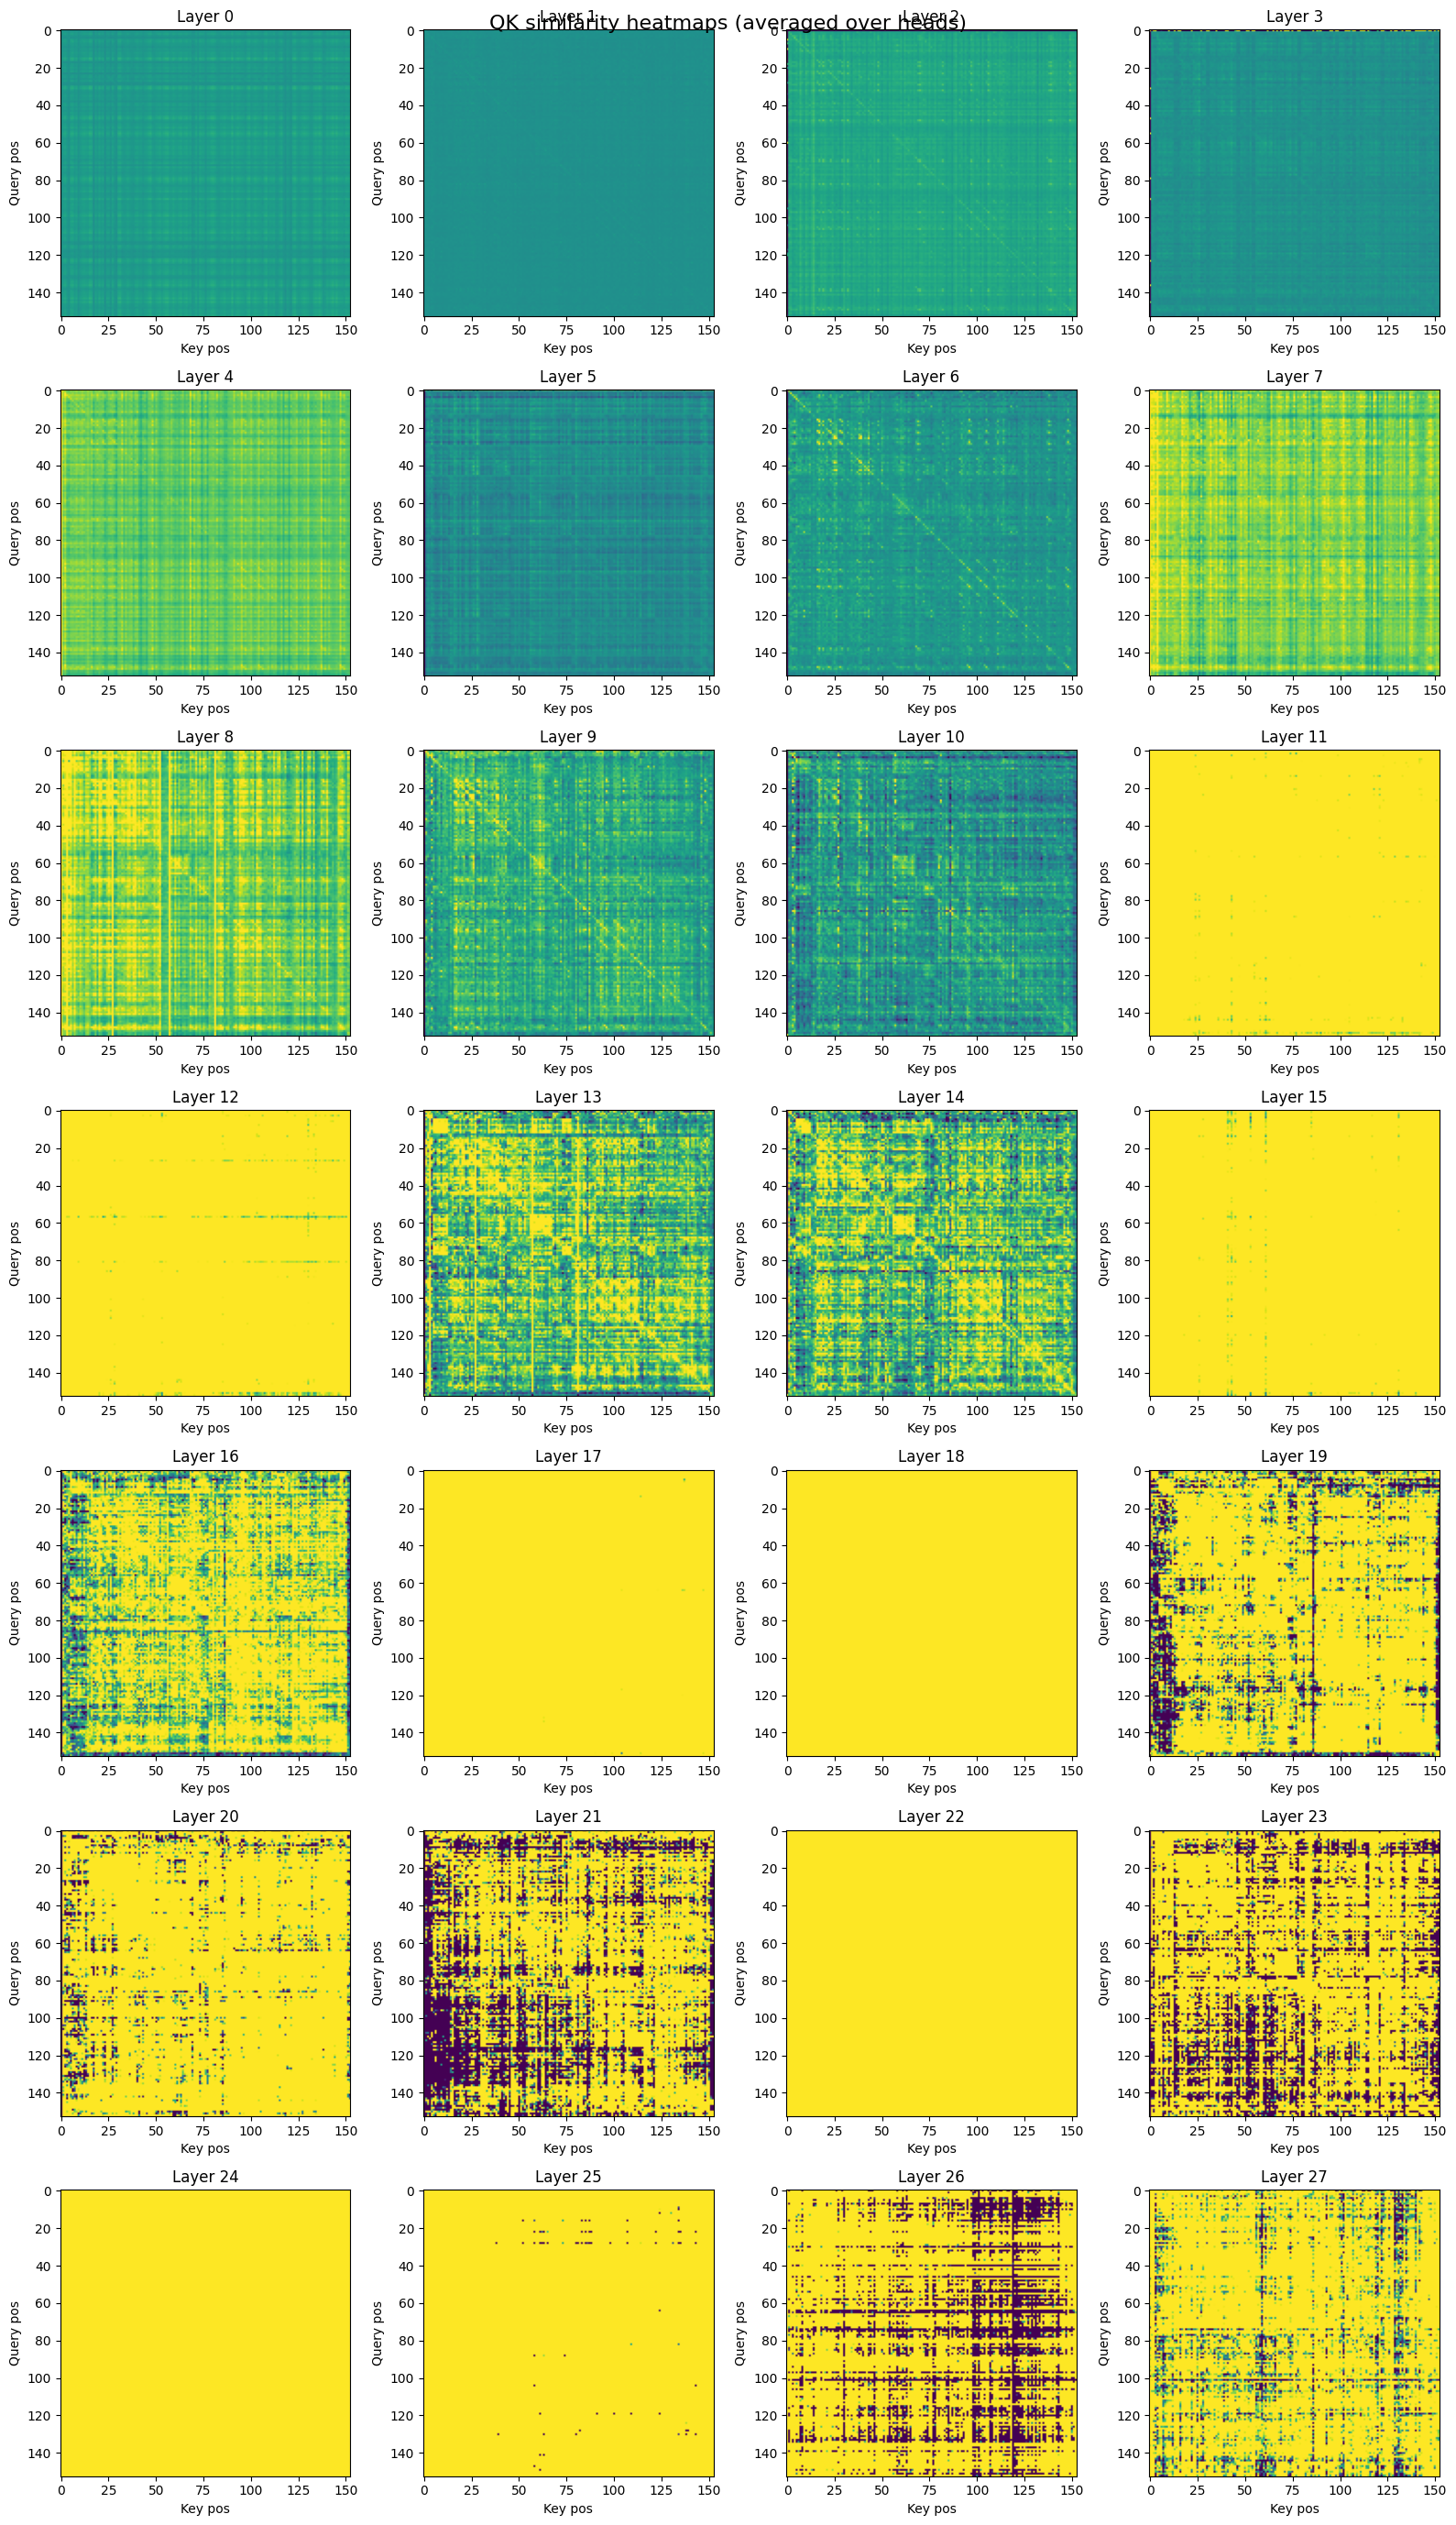

In [68]:
import torch
import matplotlib.pyplot as plt
import math

def visualize_attention_all_layers(text, model, tokenizer, device="cuda", max_layers=None, per_row=4):
    """Compute and visualize QK heatmaps for all layers from a single forward pass."""
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=False).to(device)

    with torch.no_grad():
        outputs = model(**enc, output_hidden_states=True)
        all_hiddens = outputs.hidden_states  # tuple: [emb, layer0, layer1, ...]

    n_layers = getattr(model.config, "num_hidden_layers", len(model.layers))
    if max_layers is not None:
        n_layers = min(n_layers, max_layers)

    # subplot grid
    rows = (n_layers + per_row - 1) // per_row
    fig, axes = plt.subplots(rows, per_row, figsize=(4*per_row, 4*rows))
    axes = axes.flatten()

    for layer_idx in range(n_layers):
        hidden = all_hiddens[layer_idx+1].squeeze(0).to(torch.float32)  # skip embedding
        layer = model.layers[layer_idx]

        Q = layer.self_attn.q_proj(hidden).to(torch.float32)
        K = layer.self_attn.k_proj(hidden).to(torch.float32)

        seq_len = Q.shape[0]
        q_dim, k_dim = Q.shape[-1], K.shape[-1]
        q_heads, k_heads, head_dim = _infer_heads_and_dim(model, q_dim, k_dim)

        Q = Q[:, :q_heads * head_dim].contiguous().view(seq_len, q_heads, head_dim)
        K = K[:, :k_heads * head_dim].contiguous().view(seq_len, k_heads, head_dim)

        if q_heads != k_heads:
            if q_heads % k_heads == 0:
                K = K.repeat_interleave(q_heads // k_heads, dim=1)
            elif k_heads % q_heads == 0:
                Q = Q.repeat_interleave(k_heads // q_heads, dim=1)
            else:
                common = math.gcd(q_heads, k_heads)
                Q = Q[:, :common, :]
                K = K[:, :common, :]
                q_heads = k_heads = common

        sim = torch.einsum("shd,thd->hst", Q, K) / (head_dim ** 0.5)
        sim_mean = sim.mean(dim=0).detach().cpu()

        ax = axes[layer_idx]
        sim_norm = (sim_mean - sim_mean.mean()) / (sim_mean.std() + 1e-6)
        im = ax.imshow(sim_mean, aspect="auto", vmin=-2, vmax=2)
        ax.set_title(f"Layer {layer_idx}")
        ax.set_xlabel("Key pos")
        ax.set_ylabel("Query pos")

    # remove empty subplots
    for j in range(layer_idx+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("QK similarity heatmaps (averaged over heads)", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_attention_all_layers(
    CODE_SNIPPETS[0], 
    model, tokenizer, 
    device=device
)

## 14) Prepare test cases for different prompt styles
- code snippets

In [70]:
# ===== 1) C/C++ single-function snippets across domains =====
CPP_SNIPPETS = {
    "img_conv3x3": r"""
#include <stdint.h>
void conv3x3(const uint8_t* in, uint8_t* out, int w, int h, const int k[9]) {
    for (int y=1; y<h-1; ++y) {
        for (int x=1; x<w-1; ++x) {
            int s=0, t=0;
            for (int ky=-1; ky<=1; ++ky)
                for (int kx=-1; kx<=1; ++kx)
                    s += in[(y+ky)*w + (x+kx)] * k[(ky+1)*3 + (kx+1)];
            out[y*w+x] = (uint8_t)((s<0)?0:(s>255?255:s));
        }
    }
}
""",
    "sobel_edge": r"""
#include <stdint.h>
void sobel(const uint8_t* in, uint8_t* out, int w, int h) {
    int gx[9]={-1,0,1,-2,0,2,-1,0,1}, gy[9]={-1,-2,-1,0,0,0,1,2,1};
    for (int y=1; y<h-1; ++y) {
        for (int x=1; x<w-1; ++x) {
            int sx=0, sy=0;
            for (int ky=-1; ky<=1; ++ky)
                for (int kx=-1; kx<=1; ++kx) {
                    int v=in[(y+ky)*w + (x+kx)];
                    int i=(ky+1)*3 + (kx+1);
                    sx += v*gx[i]; sy += v*gy[i];
                }
            int mag = (int)sqrtf((float)(sx*sx + sy*sy));
            out[y*w+x] = (mag>255)?255:mag;
        }
    }
}
""",
    "bilinear_resize": r"""
#include <stdint.h>
void resize_bilinear(const uint8_t* src, int sw, int sh, uint8_t* dst, int dw, int dh) {
    for (int y=0; y<dh; ++y) {
        float gy = (y + 0.5f) * sh / dh - 0.5f;
        int y0 = (int)floorf(gy), y1 = y0 + 1;
        float fy = gy - y0; if (y0<0) y0=0; if (y1>=sh) y1=sh-1;
        for (int x=0; x<dw; ++x) {
            float gx = (x + 0.5f) * sw / dw - 0.5f;
            int x0 = (int)floorf(gx), x1 = x0 + 1;
            float fx = gx - x0; if (x0<0) x0=0; if (x1>=sw) x1=sw-1;
            int c00 = src[y0*sw+x0], c01 = src[y0*sw+x1];
            int c10 = src[y1*sw+x0], c11 = src[y1*sw+x1];
            float v = (1-fy)*((1-fx)*c00 + fx*c01) + fy*((1-fx)*c10 + fx*c11);
            dst[y*dw+x] = (uint8_t)((v<0)?0:(v>255?255:v));
        }
    }
}
""",
    "fir_lowpass": r"""
#include <stddef.h>
void fir_lowpass(const float* x, float* y, size_t n, const float* h, size_t m) {
    for (size_t i=0;i<n;++i) {
        float acc=0.f;
        for (size_t k=0;k<m;++k) {
            if (i>=k) acc += h[k]*x[i-k];
        }
        y[i]=acc;
    }
}
""",
    "fft_cooley": r"""
#include <complex>
#include <vector>
void fft(std::vector<std::complex<float>>& a) {
    size_t n=a.size();
    for (size_t i=1,j=0;i<n;i++) {
        size_t bit=n>>1;
        for (; j&bit; bit>>=1) j^=bit;
        j^=bit;
        if (i<j) std::swap(a[i], a[j]);
    }
    for (size_t len=2; len<=n; len<<=1) {
        float ang = -2.0f*3.1415926535f/len;
        std::complex<float> wlen(cosf(ang), sinf(ang));
        for (size_t i=0; i<n; i+=len) {
            std::complex<float> w(1.f,0.f);
            for (size_t j=0; j<len/2; ++j) {
                auto u=a[i+j], v=a[i+j+len/2]*w;
                a[i+j]=u+v; a[i+j+len/2]=u-v; w*=wlen;
            }
        }
    }
}
""",
    "hist_eq": r"""
#include <stdint.h>
void hist_equalize(const uint8_t* in, uint8_t* out, int n) {
    int hist[256]={0};
    for (int i=0;i<n;++i) hist[in[i]]++;
    int cdf[256]={0}; cdf[0]=hist[0];
    for (int i=1;i<256;++i) cdf[i]=cdf[i-1]+hist[i];
    int total=cdf[255];
    for (int i=0;i<n;++i) out[i]=(uint8_t)((cdf[in[i]]*255)/total);
}
""",
    "bezier": r"""
struct Vec2 { float x,y; };
Vec2 bezier2(Vec2 p0, Vec2 p1, Vec2 p2, float t) {
    float u=1.0f-t;
    float bx = u*u*p0.x + 2*u*t*p1.x + t*t*p2.x;
    float by = u*u*p0.y + 2*u*t*p1.y + t*t*p2.y;
    return {bx, by};
}
""",
    "bfs": r"""
#include <vector>
#include <queue>
std::vector<int> bfs(const std::vector<std::vector<int>>& g, int s) {
    int n = (int)g.size();
    std::vector<int> dist(n, -1);
    std::queue<int> q;
    dist[s]=0; q.push(s);
    while(!q.empty()){
        int u=q.front(); q.pop();
        for(int v: g[u]) if(dist[v]==-1){
            dist[v]=dist[u]+1; q.push(v);
        }
    }
    return dist;
}
""",
    "dijkstra": r"""
#include <vector>
#include <queue>
#include <utility>
std::vector<int> dijkstra(const std::vector<std::vector<std::pair<int,int>>>& g, int s){
    int n=(int)g.size(); const int INF=1e9;
    std::vector<int> d(n, INF); d[s]=0;
    using P=std::pair<int,int>;
    std::priority_queue<P, std::vector<P>, std::greater<P>> pq;
    pq.push({0,s});
    while(!pq.empty()){
        auto [du,u]=pq.top(); pq.pop();
        if (du!=d[u]) continue;
        for(auto [v,w]: g[u]){
            if(d[v]>du+w){ d[v]=du+w; pq.push({d[v], v}); }
        }
    }
    return d;
}
""",
    "kmeans_step": r"""
#include <vector>
#include <cmath>
void kmeans_assign(const std::vector<std::vector<float>>& X,
                   const std::vector<std::vector<float>>& C,
                   std::vector<int>& idx){
    int n=(int)X.size(), k=(int)C.size();
    idx.assign(n, 0);
    for(int i=0;i<n;++i){
        float best=1e30f; int id=0;
        for(int j=0;j<k;++j){
            float s=0.f;
            for(size_t d=0; d<X[i].size(); ++d){
                float t=X[i][d]-C[j][d]; s+=t*t;
            }
            if(s<best){ best=s; id=j; }
        }
        idx[i]=id;
    }
}
""",
}

# ===== 2) Prompt builders: plain / instruct / cot =====
def build_text(snippet: str, mode: str = "plain") -> str:
    """
    mode = "plain": just the code.
    mode = "instruct": wrap the code with an instruction-style prompt.
    mode = "cot": same as instruct but appends a reasoning cue.
    """
    snippet = snippet.strip()
    if mode == "plain":
        return snippet
    instr_header = (
        "You are a senior C++ engineer. "
        "Summarize the function's domain (e.g., image/audio/graph/numeric), "
        "its core algorithm, inputs/outputs, and complexity. "
        "Be concise.\n\n"
        "Code:\n"
    )
    text = instr_header + snippet + "\n\nAnswer:"
    if mode == "cot":
        text += " Let's think step by step."
    return text

print("Prepared", len(CPP_SNIPPETS), "snippets.")


Prepared 10 snippets.


## 15) Plain, Instructed, and CoT
- Compare embeddings for different prompt styles

[plain] embeddings shape: torch.Size([10, 1024])


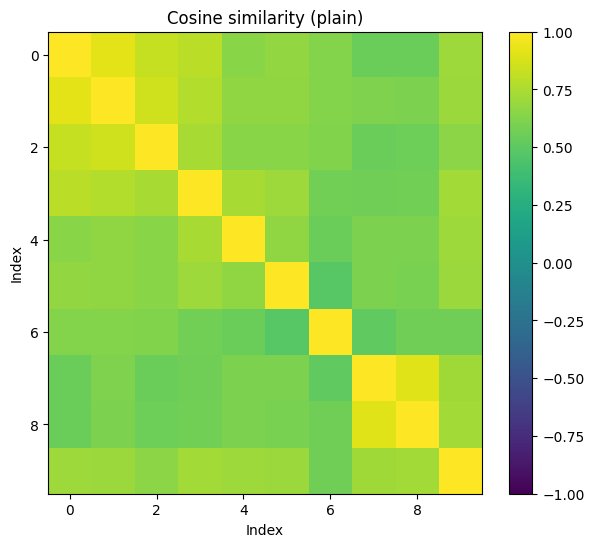

[instruct] embeddings shape: torch.Size([10, 1024])


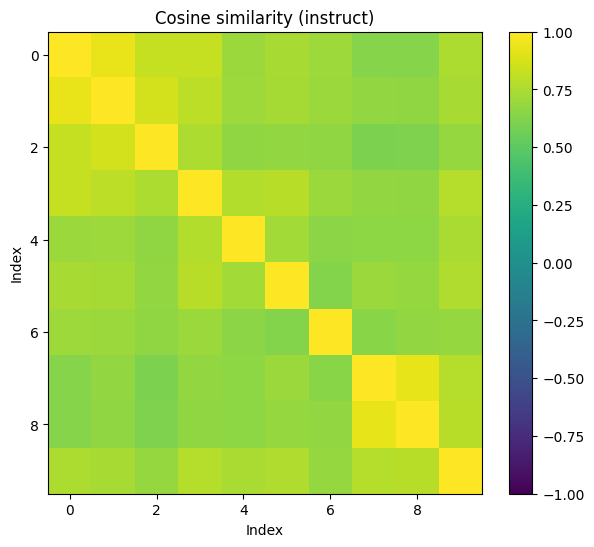

[cot] embeddings shape: torch.Size([10, 1024])


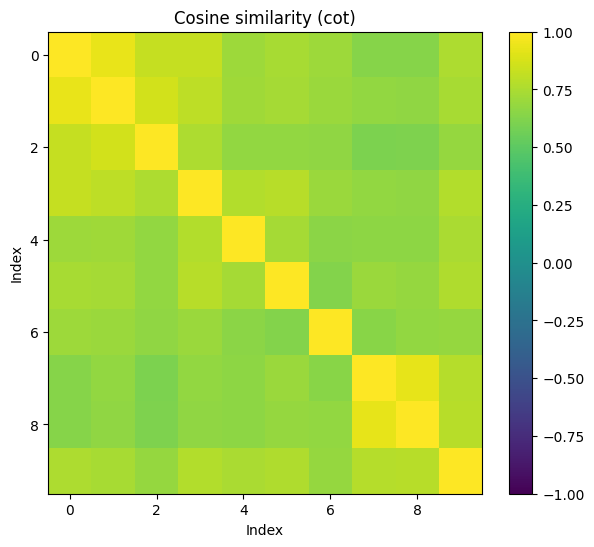

In [71]:
import torch
import matplotlib.pyplot as plt

@torch.inference_mode()
def encode_texts_mean_pool(texts, tokenizer, model, device="cuda"):
    """
    Return a tensor [N, hidden] by mean-pooling last_hidden_state for each input text.
    """
    embs = []
    for t in texts:
        enc = tokenizer(t, return_tensors="pt", truncation=True, padding=False).to(device)
        out = model(**enc, output_hidden_states=True)
        last = out.last_hidden_state.squeeze(0).to(torch.float32)  # [seq, hidden]
        embs.append(last.mean(dim=0))                               # [hidden]
    return torch.stack(embs, dim=0)                                 # [N, hidden]

def cosine_sim_matrix(X: torch.Tensor) -> torch.Tensor:
    """
    Compute cosine similarity matrix for rows of X. Returns [N, N].
    """
    X = X.to(torch.float32)
    X = X / (X.norm(dim=1, keepdim=True) + 1e-8)
    return X @ X.T

def plot_heatmap_torch(mat: torch.Tensor, title="Similarity", vmin=-1.0, vmax=1.0):
    mat_cpu = mat.detach().cpu()
    plt.figure(figsize=(7,6))
    plt.imshow(mat_cpu, aspect="auto", vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Index")
    plt.show()

# ==== Build a corpus in three modes and compare ====
modes = ["plain", "instruct", "cot"]

for mode in modes:
    texts = [build_text(src, mode) for src in CPP_SNIPPETS.values()]
    Z = encode_texts_mean_pool(texts, tokenizer, model, device=device)   # [N, hidden]
    S = cosine_sim_matrix(Z)                                              # [N, N]
    print(f"[{mode}] embeddings shape:", Z.shape)
    plot_heatmap_torch(S, title=f"Cosine similarity ({mode})", vmin=-1, vmax=1)


In [73]:
snippet_huff_A = r"""/* Huffman variant A ... paste here ... */"""
snippet_huff_B = r"""/* Huffman variant B ... paste here ... */"""

pairs = [("plain", build_text(snippet_huff_A, "plain"), build_text(snippet_huff_B, "plain")),
         ("instruct", build_text(snippet_huff_A, "instruct"), build_text(snippet_huff_B, "instruct")),
         ("cot", build_text(snippet_huff_A, "cot"), build_text(snippet_huff_B, "cot"))]

@torch.inference_mode()
def encode_one(text):
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=False).to(device)
    out = model(**enc, output_hidden_states=True)
    last = out.last_hidden_state.squeeze(0).to(torch.float32)
    return last.mean(dim=0)

def cos(a, b):
    a = a / (a.norm() + 1e-8)
    b = b / (b.norm() + 1e-8)
    return float((a * b).sum().item())

for name, ta, tb in pairs:
    ea = encode_one(ta)
    eb = encode_one(tb)
    s  = cos(ea, eb)
    print(f"{name:9s} cosine = {s:.4f}")


plain     cosine = 0.9752
instruct  cosine = 0.9986
cot       cosine = 0.9978
